In [3]:
import safe

ibuprofen = "CC(Cc1ccc(cc1)C(C(=O)O)C)C"

# SMILES -> SAFE -> SMILES translation
try:
    ibuprofen_sf = safe.encode(ibuprofen)  # c12ccc3cc1.C3(C)C(=O)O.CC(C)C2
    ibuprofen_smi = safe.decode(ibuprofen_sf, canonical=True)  # CC(C)Cc1ccc(C(C)C(=O)O)cc1
except safe.EncoderError:
    pass
except safe.DecoderError:
    pass

ibuprofen_tokens = list(safe.split(ibuprofen_sf))
print(ibuprofen_tokens)

['c', '1', '2', 'c', 'c', 'c', '3', 'c', 'c', '1', '.', 'C', '3', '(', 'C', ')', 'C', '(', '=', 'O', ')', 'O', '.', 'C', 'C', '(', 'C', ')', 'C', '2']


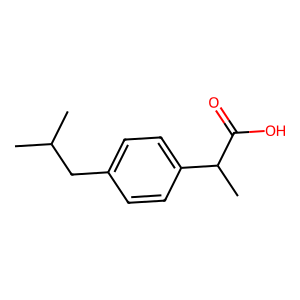

In [6]:
import safe as sf
import datamol as dm

ibuprofen_mol = dm.to_mol(ibuprofen)

display(dm.to_image(ibuprofen_mol))


## TRAINING

In [7]:
# Loading the dataset:
from datasets import load_dataset
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

train_dataset = load_dataset("datamol-io/safe-gpt",split ="train[:5%]")
eval_dataset = load_dataset("datamol-io/safe-gpt",split ="test[10%:15%]")


In [8]:
# print a random sample:
print(eval_dataset[0]['input'])

Cc1ccc4cc1.C14(C)N=C(O)N5C1=O.C5C6=O.N67C.C78.C18CCC1


In [9]:
from safe.tokenizer import SAFETokenizer
from safe.trainer.collator import SAFECollator

tokenizer = SAFETokenizer().load("./tokenizer.json")
tokenizer = tokenizer.get_pretrained()
tokenizer.model_max_length = 512

print(tokenizer(eval_dataset[0]['input']))

{'input_ids': [1, 27, 54, 14, 54, 54, 54, 17, 54, 54, 14, 11, 27, 14, 17, 7, 27, 8, 37, 23, 27, 7, 38, 8, 37, 18, 27, 14, 23, 38, 11, 27, 18, 27, 19, 23, 38, 11, 37, 19, 20, 27, 11, 27, 20, 21, 11, 27, 14, 21, 27, 27, 27, 14, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
# Load the model configuration
# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5")

# # Resize the model embeddings to match the new tokenizer
# model.resize_token_embeddings(len(tokenizer))
# model.save_pretrained("phi1_5_updated")

In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig
from accelerate import init_empty_weights
def get_device_map() -> str:
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device_map()  # 'cpu'

model_id = "microsoft/phi-1_5"
config = None
config = AutoConfig.from_pretrained(model_id)

config.vocab_size = len(tokenizer)
config.max_position_embeddings = 512

config.bos_token_id = tokenizer.bos_token_id
config.eos_token_id = tokenizer.eos_token_id
config.pad_token_id = tokenizer.pad_token_id
config.task_type = "causal_lm"

from transformers import BitsAndBytesConfig
import torch
quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,)
with init_empty_weights():
     model = AutoModelForCausalLM.from_pretrained("phi1_5_updated", 
                                             config=config,
                                             ignore_mismatched_sizes=True,
                                             quantization_config=quantization_config, 
                                             device_map="auto",
                                             torch_dtype=torch.float16,
                                             low_cpu_mem_usage=True,
                                             attn_implementation="flash_attention_2"
                                             )
model.tie_weights()

from peft import prepare_model_for_kbit_training
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
from peft import LoraConfig, get_peft_model, TaskType
# based on config
peft_config = LoraConfig(
        r=16,
        lora_alpha=8,
        lora_dropout=0.1,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 4,718,592 || all params: 1,220,925,272 || trainable%: 0.3865


In [12]:
# We need to unfreeze the token embeddings because we changed the tokenizer

embed_tokens_layer = model.base_model.model.model.embed_tokens
# Unfreeze the parameters of embed_tokens
for param in embed_tokens_layer.parameters():
    param.requires_grad = True
# Optionally, verify that the parameters are unfrozen
for name, param in model.named_parameters():
    if 'embed_tokens' in name:
        print(f"{name} requires_grad: {param.requires_grad}")

base_model.model.model.embed_tokens.weight requires_grad: True


In [13]:
model.print_trainable_parameters()

trainable params: 8,568,832 || all params: 1,220,925,272 || trainable%: 0.7018


In [14]:
import re
import logging
from typing import Optional

logger = logging.getLogger(__name__)

class SAFESplitter:
    """Standard Splitter for SAFE string"""

    REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""

    name = "safe"

    def __init__(self, pattern: Optional[str] = None):
        if pattern is None:
            pattern = self.REGEX_PATTERN
        self.regex_pattern = pattern
        self.regex = re.compile(pattern)

    def tokenize(self, line):
        """Tokenize a safe string into characters."""
        if isinstance(line, str):
            tokens = list(self.regex.findall(line))
            reconstruction = "".join(tokens)
            if line != reconstruction:
                logger.error(
                    f"Tokens different from sample:\ntokens {reconstruction}\nsample {line}."
                )
                raise ValueError(line)
        else:
            idxs = re.finditer(self.regex, str(line))
            tokens = [line[m.start(0) : m.end(0)] for m in idxs]
        return tokens

    def detokenize(self, chars):
        """Detokenize SAFE notation"""
        if isinstance(chars, str):
            chars = chars.split(" ")
        return "".join([x.strip() for x in chars])

import datasets

# Assume `train_dataset` and `eval_dataset` are your datasets

# Initialize your custom splitter
splitter = SAFESplitter()

def custom_tokenize(example):
    # Check if 'input' key exists and is not None
    if 'input' in example and example['input'] is not None:
        # Apply your custom tokenization logic
        tokens = splitter.tokenize(example['input'])
        # Join tokens with spaces (or any other suitable delimiter) to create a single string
        return {"input": " ".join(tokens)}
    else:
        # Return an empty dictionary to effectively skip this example
        return {}

def filter_empty_examples(example):
    # Filter out empty examples
    if 'input' in example and example['input']:
        return True
    else:
        logger.info(f"Filtering out empty example: {example}")
        return False

# Apply the custom tokenization to the datasets
train_dataset = train_dataset.map(custom_tokenize, batched=False, num_proc=32)
eval_dataset = eval_dataset.map(custom_tokenize, batched=False, num_proc=32)

# Filter out the empty examples
train_dataset = train_dataset.filter(filter_empty_examples, num_proc=32)
eval_dataset = eval_dataset.filter(filter_empty_examples, num_proc=32)

In [15]:
from tokenizers.pre_tokenizers import PreTokenizer, Whitespace

tokenizer._tokenizer.pre_tokenizer = Whitespace()

In [16]:
from transformers import TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig
from safe.trainer.collator import SAFECollator

trained_model_id = "phi1_5-safmol"

output_dir = '.saved_model/' + trained_model_id

# based on config
training_args = TrainingArguments(
    fp16=False, # specify bf16=True instead when training on GPUs that support bf16 else fp16
    bf16=False,
    tf32 = True,
    do_eval=True,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    learning_rate=2.0e-05,
    log_level="info",
    optim = "paged_adamw_8bit" ,
    logging_steps=10,
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    max_steps=-1,
    num_train_epochs=1,
    output_dir=output_dir,
    overwrite_output_dir=True,
    eval_accumulation_steps=1,
    per_device_eval_batch_size=1, # originally set to 8
    per_device_train_batch_size=18, # originally set to 8
    push_to_hub=True,
    hub_model_id=trained_model_id,
    # hub_strategy="every_save",
    # report_to="tensorboard",
    report_to="none",  # for skipping wandb logging
    save_strategy="steps",
    eval_strategy="steps",
    eval_steps=10,
    save_total_limit=None,
    save_steps =100,
    torch_compile = True,
    seed=42,
)


trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        dataset_text_field="input",
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=512,
        dataset_num_proc = 64,
        data_collator=SAFECollator(tokenizer,input_key="input",max_length=512)

    )

# To clear out cache for unsuccessful run
torch.cuda.empty_cache()

train_result = trainer.train()
# resume_from_checkpoint=checkpoint_path

/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
***** Running training *****
  Num examples = 47,272,765
  Num Epochs = 1
  Instantaneous batch size per device = 18
  Total train batch size (w. parallel, distributed & accumulation) = 36
  Gradient Accumulation steps = 2
  Total optimization steps = 1,313,132
  Number of trainable parameters = 8,568,832
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To

Epoch,Training Loss,Validation Loss


/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Saving model checkpoint to .saved_model/phi1_5-safmol/checkpoint-100
tokenizer config file saved in .saved_model/phi1_5-safmol/checkpoint-100/tokenizer_config.json
Special tokens file saved in .saved_model/phi1_5-safmol/checkpoint-100/special_tokens_map.json
tokenizer config file saved in .saved_model/phi1_5-safmol/tokenizer_config.json
Special tokens file saved in .saved_model/phi1_5-safmol/special_tokens_map.json
/home/thomas/anaconda3/envs/safemol/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import safe

# Load the trained model and tokenizer
model_id = "./.saved_model/phi1_5-safmol"
tokenizer = AutoTokenizer.from_pretrained(model_id+"/checkpoint-100")
model = AutoModelForCausalLM.from_pretrained(model_id)

# Set the model to evaluation mode
model.eval()

# Define generation parameters
generation_args = {
    "max_length": 50,  # Adjust the maximum length of the generated sequence
    "num_return_sequences": 1,  # Number of sequences to generate
    "temperature": 1.0,  # Sampling temperature
    "top_k": 50,  # Top-k sampling
    "top_p": 0.95,  # Top-p (nucleus) sampling
    "do_sample": True,  # Use sampling instead of greedy decoding
}

# Generate a sequence without a prompt
input_ids = torch.tensor([[tokenizer.pad_token_id]])  # Use the pad token ID as a dummy input

with torch.no_grad():
    generated_sequences = model.generate(input_ids, **generation_args)

# Decode the generated sequence
generated_text = tokenizer.decode(generated_sequences[0], skip_special_tokens=True)

print("Generated text:", generated_text)
print("SMILES: ", safe.decode(generated_text, canonical=True) )


loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file phi1_5_updated/config.json
Model config PhiConfig {
  "_name_or_path": "phi1_5_updated",
  "architectures": [
    "PhiForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": null,
  "embd_pdrop": 0.0,
  "eos_token_id": null,
  "hidden_act": "gelu_new",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "phi",
  "num_attention_heads": 32,
  "num_hidden_layers": 24,
  "num_key_value_heads": 32,
  "partial_rotary_factor": 0.5,
  "qk_layernorm": false,
  "resid_pdrop": 0.0,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.41.1",
  "use_cache": true,
  "vocab_size": 1880
}

loading weights file phi1_5_updated/model.safetensors
Generat

Generated text: [N5P][Th][N3[Sc+2][Th]%1B%47[Br-]2+][Br-][Br-]g+][14[Th][N3[17F][Th][N5[Ni-4][Br-]2+][Br-][Br-][N5P][Th][N3B[Br-][Br-][N4P][Th][N5[Sc+2][Th]%1


SAFEDecodeError: Failed to decode [N5P][Th][N3[Sc+2][Th]%1B%47[Br-]2+][Br-][Br-]g+][14[Th][N3[17F][Th][N5[Ni-4][Br-]2+][Br-][Br-][N5P][Th][N3B[Br-][Br-][N4P][Th][N5[Sc+2][Th]%1

In [12]:
import random
# Set model_max_length to 512
tokenizer.model_max_length = 512

# Define the fraction of the dataset to sample
fraction = 0.0001  # 1% of the dataset

# Sample a fraction of the dataset
sample_size = int(len(train_dataset) * fraction)
sample_indices = random.sample(range(len(train_dataset)), sample_size)
sampled_dataset = train_dataset.select(sample_indices)

# Tokenize the sampled dataset
def tokenize_function(example):
    return tokenizer(example['input'], truncation=True, padding='max_length', max_length=tokenizer.model_max_length)

tokenized_dataset = sampled_dataset.map(tokenize_function, batched=True,num_proc=10)

# Check the length of the tokenized inputs
input_lengths = [len(input_ids) for input_ids in tokenized_dataset['input_ids']]
print("Tokenized input lengths:", input_lengths)

# Optionally, print some statistics about the lengths
import numpy as np

print("Mean tokenized input length:", np.mean(input_lengths))
print("Max tokenized input length:", np.max(input_lengths))
print("Min tokenized input length:", np.min(input_lengths))

Map (num_proc=10): 100%|██████████| 4727/4727 [00:00<00:00, 6848.09 examples/s]


Tokenized input lengths: [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,